In [0]:
from google.colab import drive
drive.mount("/content/drive")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#This notebook is currently not working well with too much manual coding...
#it does aggregates data over >10 games, but in many cases it returns null for some data cleaning issue
#probably because of hard coding so many things with try and pass
#in future solving these issue and increasing sample size would be useful

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time as tm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:

def get_duration(start_time_point, end_time_array):
  x = end_time_array - start_time_point
  x = x[x>0]
  if len(x)>0:
    return (min(x))
  else:
    return (0) #just dummy, 0ms means that it is not a valid action anyways

def output_action_periods(df_large, playerID=67348, rolling_window_n=100, 
                          min_action_length=1, min_speed=3, output_file_path="path"):
  #everything is in the order of "second" and "meter", not mili second
  df = df_large[df_large.playerID==playerID]
  #if null, return null and done 
  try:
    #calculate dt [s]
    tm = np.array(df.timestamp)
    dt = (tm - np.array([tm[0]] + list(tm[:-1]))) /10**3
    #calculate dp (position) [m]
    x = np.array(df.X)
    y = np.array(df.Y)
    x_before = np.array([x[0]] + list(x[:-1]))
    y_before = np.array([y[0]] + list(y[:-1]))
    dp = np.sqrt( (x - x_before)**2 + (y - y_before)**2 ) /10**3
    #v = dp / dt [m/s]
    v = np.array(dp/dt)
    #filter out the head, concat with the df
    df = df.iloc[1:,:]
    df["v"] = v[1:]
    #roll the df
    df.index = df.timestamp

    dfroll = df[["timestamp","v", "X", "Y"]].rolling(window=rolling_window_n).mean() #100 ~= 1s resolution 
    vroll = np.array(dfroll.v)

    #annotate the action moment
    vroll_before = np.array([vroll[0]] + list(vroll[:-1]))
    action_started = np.array((vroll>=min_speed)&(vroll_before<min_speed)) #when >=3m/s
    action_ended = np.array((vroll<min_speed)&(vroll_before>=min_speed)) #when < than 3m/s

    dfroll["action_started"] = action_started
    dfroll["action_ended"] = action_ended

    starttime = np.array(dfroll[dfroll.action_started].timestamp)
    endtime =  np.array(dfroll[dfroll.action_ended].timestamp)
    action_duration = np.array(pd.Series(starttime).apply(lambda x: get_duration(x, endtime)))#for each starttime, getting the end time.

    dfaction = dfroll[dfroll.action_started]
    dfaction["action_duration"] = action_duration / 10**3 #second
    dfaction = dfaction[dfaction.action_duration>min_action_length]

    dfaction.to_csv(output_file_path, sep="\t")
    print ("wrote {0} actions for player {1}".format(dfaction.shape, playerID))
  except:
    print ("somehow couldn't write actions for player {1}".format(dfaction.shape, playerID))
    pass


def annotate_ontheball(t, x, y, balldf, dist_thres = 0.5): #True if on the ball, = within 50cm 
  balldf = balldf[abs(balldf.timestamp - t) < 200] #let's do 0.2s from action start
  if balldf.shape[0]==0:
    return (False) #no ball around. good.
  else:
    dist_min = min(np.sqrt( (balldf.X-x)**2 + (balldf.Y-y)**2 )) / 10**3 #meter
    return (dist_min<0.5)



def get_nearby_consequence_score(time, events, cutoff=10, flip=False): 
  #if things are not within 10s of the action start, then no count
  #flip=True if it is their action
  df = events[events.Timestamp>time] #after the action only
  if df.shape[0] == 0:
    return (0)
  df = df.head(1) #because it is sorted, taking the first element is fine
  if df.Timestamp.values[0] - time > cutoff*10**3: 
    return (0) #doesn't count if more than 10s = 10*10**3 ms
  else:
    score = df.action_score.values[0]
    if flip: 
      score = score * -1
    return (score)


def score_all_action(events, actions, teamID):
  #1. score my team action
  my_team_events = events[events.TeamId==teamID]
  s1 = actions.timestamp.apply(lambda x: get_nearby_consequence_score(x, my_team_events))
  their_team_events = events[events.TeamId != teamID]
  s2 = actions.timestamp.apply(lambda x: get_nearby_consequence_score(x, their_team_events, flip=True))
  return (np.array(s1) + np.array(s2)) #returing the score of the action (in future: also the events)



In [0]:
#get the n(action), oasis, n(score), n(assist) for all the (man) games

#first, make sure glob works
import glob
basepaths = glob.glob("/content/drive/My Drive/ssac_hackthon_2020/explore-shottracker/timeseries/*")

In [0]:
basepaths = basepaths[1::2] #.zip is not needed

In [0]:
gameIDs = pd.Series(basepaths).apply(lambda x: x.split("/")[-1])

0     M_17472065-4ad8-11ea-9084-0242bdc61da9
1     M_8279c1d6-4e02-11ea-ab59-024282923f19
2     M_9672b049-537c-11ea-ab59-024282923f19
3     M_a8114fce-5374-11ea-ab59-024282923f19
4     M_aa5ba87c-4d2a-11ea-b7ea-0242bdc61da9
5     M_ea97103a-537c-11ea-ab59-024282923f19
6     W_07ae9e9b-4abd-11ea-83c8-024282923f19
7     W_2b3db632-4ab2-11ea-83c8-024282923f19
8     W_44b3de9b-537c-11ea-8152-0242bdc61da9
9     W_5d8a1134-4aa5-11ea-83c8-024282923f19
10    W_75e1e858-4aa5-11ea-9084-0242bdc61da9
11    W_9abe2d1d-4841-11ea-9084-0242bdc61da9
dtype: object

In [0]:
## this doesn't go through to the end so far.. probably need to make it generalizable in different ways

#get the actions for all the games
outpath_base = "/content/drive/My Drive/ssac_hackthon_2020/action_output_test/"
for i in range(len(basepaths)): #for each game
  gameID = gameIDs[i]

  #get unique player ID first
  heads = pd.read_csv("/content/drive/My Drive/ssac_hackthon_2020/explore-shottracker/timeseries/{0}/{0}_playerLocations.csv".format(gameID), 
                          sep=",", nrows = 100000)
  players = heads.playerID.unique()


  #do by chunk
  chunksize = 1000000
  reader = pd.read_csv("/content/drive/My Drive/ssac_hackthon_2020/explore-shottracker/timeseries/{0}/{0}_playerLocations.csv".format(gameID), 
                          sep=",", chunksize=chunksize)
  i = 0
  for chunk in reader:
    for player in players:
      player = int(player)
      outpath = outpath_base+ gameID + str(player)+"_chunk{0}.tsv".format(i)
      output_action_periods(chunk, playerID=player, output_file_path = outpath)
    i += 1
    print ("done chunk {0}".format(i))
    print (tm.ctime())

  #and collect
  outpath_base = "/content/drive/My Drive/ssac_hackthon_2020/action_output_test/"
  for player in  players:
    player = int(player)
    print ("starting player {0}".format(player))
    dfall = []
    fnum = len(glob.glob(outpath_base+gameID+str(player)+"_chunk*.tsv")) #number of chunks
    for i in range(fnum):  
      outpath = outpath_base+gameID+str(player)+"_chunk{0}.tsv".format(i)
      try:
        df = pd.read_csv(outpath, sep="\t")
        if df.shape[0]>0:  
          dfall.append(df)
      except:
        pass
    if len(dfall)>0:
      dfall = pd.concat(dfall, axis=0)
      print ("final shape:")
      print(dfall.shape)
      dfall.to_csv(outpath_base+gameID+str(player)+"allchunk.tsv", sep="\t")



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel

wrote (9, 7) actions for player 67348
wrote (15, 7) actions for player 67351
wrote (16, 7) actions for player 67346
wrote (18, 7) actions for player 67363
wrote (15, 7) actions for player 67361
wrote (0, 7) actions for player 67342
wrote (20, 7) actions for player 67367
wrote (0, 7) actions for player 75482
wrote (0, 7) actions for player 67344
wrote (16, 7) actions for player 67339
wrote (0, 7) actions for player 75487
wrote (0, 7) actions for player 67364
wrote (12, 7) actions for player 79832
wrote (9, 7) actions for player 67368
wrote (0, 7) actions for player 75486
wrote (0, 7) actions for player 67347
wrote (0, 7) actions for player 67337
wrote (0, 7) actions for player 80073
wrote (13, 7) actions for player 67365
wrote (0, 7) actions for player 75481
wrote (0, 7) actions for player 67340
wrote (1, 7) actions for player 67369
done chunk 1
Fri Mar  6 22:40:01 2020
wrote (4, 7) actions for player 67348
wrote (5, 7) actions for player 67351
wrote (3, 7) actions for player 67346
wrot

UnboundLocalError: ignored

In [0]:
#also define the score for each event in the game
score_dict = {"STL":1, "TO":1, "FL":-1, "DEFENSIVE_REB":0.5, "OFFENSIVE_REB":0.2, 
                "FG2":2, "FG3":3, "PASS3_5":0.2, "PASS6":0.4, "PT0":0.2, "TRANSITION":1}

for i in range(len(basepaths)): #for each game
  gameID = gameIDs[i]
  try:
    events = pd.read_csv("/content/drive/My Drive/ssac_hackthon_2020/explore-shottracker/playbyplay/{0}.csv".format(gameID), sep=",")
    for key in score_dict.keys():
      events.loc[~np.array(events[key].isna()), "action_score"] = score_dict[key]
    events.dropna(subset=['action_score'], inplace=True)
    events.to_csv("/content/drive/My Drive/ssac_hackthon_2020/play_output_test/{0}_playscores.tsv".format(gameID), sep="\t")
    print ("whote {0}".format(gameID))
  except:
    print ("couldn't write {0} somehow".format(gameID))


In [0]:
#now, score each player in each game
for i in range(len(basepaths)): #for each game
  gameID = gameIDs[i]
  print ("starting game {0}".format(gameID))
  print (tm.ctime())
  try:
    heads = pd.read_csv("/content/drive/My Drive/ssac_hackthon_2020/explore-shottracker/timeseries/{0}/{0}_playerLocations.csv".format(gameID), 
                            sep=",", nrows = 100000)
    players = heads.playerID.unique()

    events = pd.read_csv("/content/drive/My Drive/ssac_hackthon_2020/play_output_test/{0}_playscores.tsv".format(gameID), sep="\t")

    ballloc = pd.read_csv("/content/drive/My Drive/ssac_hackthon_2020/explore-shottracker/timeseries/{0}/{0}_ballLocations.csv".format(gameID), sep=",")
    ballloc_approx = ballloc.iloc[::10,:] #1 in 10 = 1 in 0.1s, to reduce the search space

    for player in players:#for each player
      action_data_path = "/content/drive/My Drive/ssac_hackthon_2020/action_output_test/{0}{1}allchunk.tsv".format(gameID, int(player))
      actions = pd.read_csv(action_data_path, sep="\t", index_col=0)
      
      #only if the player is relevant to any event:
      if sum(events.PlayerId==player)>0:
        #get the team ID for the player
        my_team_ID = events[events.PlayerId==player].TeamId.unique()[0]

        #filter to off-the-ball actions
        actions["on_the_ball"] = actions.apply(lambda l: annotate_ontheball(l["timestamp"], l["X"], l["Y"], ballloc_approx), axis=1)
        actions = actions[~actions.on_the_ball]
        #and get the score
        action_scores = score_all_action(events, actions, teamID=my_team_ID)
        #save it as a dataframe
        pd.Series(action_scores).to_csv("/content/drive/My Drive/ssac_hackthon_2020/play_output_test/action_scores_game{0}player{1}.tsv".format(gameID, player), sep="\t")
        print ("done scoring player {0}".format(player))
        print (tm.ctime())
  except:
    print ("something went wrong")
    pass





In [0]:
#for each game, get the stats including oasis

outpath_base = "/content/drive/My Drive/ssac_hackthon_2020/action_output_test/"
for i in range(len(basepaths)): #for each game
  gameID = gameIDs[i]
  heads = pd.read_csv("/content/drive/My Drive/ssac_hackthon_2020/explore-shottracker/timeseries/{0}/{0}_playerLocations.csv".format(gameID), 
                        sep=",", nrows = 100000)
  players = heads.playerID.unique() #to get the list of active players
  #get the action count
  action_num = {} 
  for player in  players: #for each player
      try:
        df = pd.read_csv(outpath_base+gameID+str(player)+"allchunk.tsv", sep="\t")
        action_num[player] = df.shape[0]
      except:
        pass
  action_num = pd.DataFrame(action_num, index=["action_num"]).T
  #get the OASiS
  scores = {}
  for player in players:
    try:
      sc = pd.read_csv("/content/drive/My Drive/ssac_hackthon_2020/play_output_test/action_scores_game{0}player{1}.tsv".format(gameID, player), sep="\t", index_col=0)
      scores[player] = sc.sum().values[0]
    except: 
      pass
  oasis = pd.DataFrame(scores, index=["oasis"]).T
  #get the points and assists 
  try:        
    events = pd.read_csv("/content/drive/My Drive/ssac_hackthon_2020/explore-shottracker/playbyplay/{0}.csv".format(gameID), sep=",")
    events.dropna(subset=["PlayerId"], inplace=True)
    events["playerID_int"] = events.PlayerId.astype(int)
    agged = events.groupby("playerID_int")["FG3", "FG2", "AST"].agg("sum")
    agged["goals"] = agged.FG3*3 + agged.FG2*2
    agged = agged.join(oasis).join(action_num).dropna()
    agged["gameID"] = gameID
    agged.to_csv(outpath_base + gameID + "_oasis_stats.tsv", sep="\t")
    print ("done game {0}".format(gameID))
    print (tm.ctime())
  except:
    pass


#Hmmm only 1 game at the end of the day.. why??

#tryの入れ方悪いぽい

In [0]:
#aggregate everything and make it as a single dataframe
df = []
for i in range(len(basepaths)): #for each game
  gameID = gameIDs[i]
  try:
    dfsub  =pd.read_csv(outpath_base + gameID + "_oasis_stats.tsv", sep="\t")
    df.append(dfsub)
    print ("appended game {0}".format(gameID))
  except:
    pass

appended game M_17472065-4ad8-11ea-9084-0242bdc61da9
appended game M_8279c1d6-4e02-11ea-ab59-024282923f19
appended game M_9672b049-537c-11ea-ab59-024282923f19
appended game M_a8114fce-5374-11ea-ab59-024282923f19
appended game M_aa5ba87c-4d2a-11ea-b7ea-0242bdc61da9
appended game M_ea97103a-537c-11ea-ab59-024282923f19
appended game W_07ae9e9b-4abd-11ea-83c8-024282923f19
appended game W_2b3db632-4ab2-11ea-83c8-024282923f19
appended game W_44b3de9b-537c-11ea-8152-0242bdc61da9
appended game W_5d8a1134-4aa5-11ea-83c8-024282923f19
appended game W_75e1e858-4aa5-11ea-9084-0242bdc61da9


In [0]:
df = pd.concat(df, axis=0)

In [0]:
df.head()

,playerID_int,FG3,FG2,AST,goals,oasis,action_num,gameID
0,67337,0.0,1.0,0.0,2.0,-1.5,44.0,M_17472065-4ad8-11ea-9084-0242bdc61da9
1,67339,3.0,4.0,3.0,17.0,17.9,164.0,M_17472065-4ad8-11ea-9084-0242bdc61da9
2,67342,0.0,1.0,0.0,2.0,1.7,42.0,M_17472065-4ad8-11ea-9084-0242bdc61da9
3,67344,0.0,0.0,1.0,0.0,6.0,52.0,M_17472065-4ad8-11ea-9084-0242bdc61da9
4,67346,1.0,1.0,2.0,5.0,2.4,146.0,M_17472065-4ad8-11ea-9084-0242bdc61da9


In [0]:
df.shape

(49, 8)

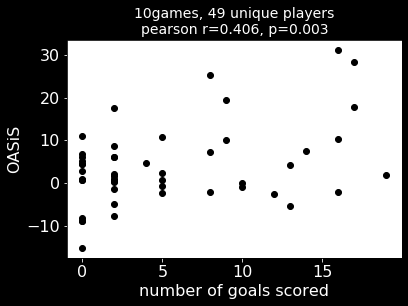

In [0]:
#now it has weak correlation with the score itself, but still providing orthogonal score metric

from scipy import stats
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'black'

plt.scatter(df.goals, df.oasis, color="black")
pr, pval = stats.pearsonr(df.goals, df.oasis)
plt.title("10games, 49 unique players\npearson r={0}, p={1}".format(str(pr)[:5], str(pval)[:5]), color="white", size=14)
plt.xlabel("number of goals scored")
plt.ylabel("OASiS")
plt.show()